In [85]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)

In [86]:
# Import the training dataset with only the important colums
train_dataset = pd.read_csv("nlp-getting-started/train.csv", usecols=[3, 4])

# Column 3 is the column of interest in the testing set
test_dataset = pd.read_csv("nlp-getting-started/test.csv", usecols=[3])

In [87]:
#Print first 5 elements of the train dataset
print("Training set: ", train_dataset.head())

Training set:                                                  text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


In [88]:
#Print first 5 elements of the test dataset
print("Testing set: ", test_dataset.head())

Testing set:                                                  text
0                 Just happened a terrible car crash
1  Heard about #earthquake is different cities, s...
2  there is a forest fire at spot pond, geese are...
3           Apocalypse lighting. #Spokane #wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan


In [89]:
#check for duplicates in the dataset
display(train_dataset.text.describe())

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

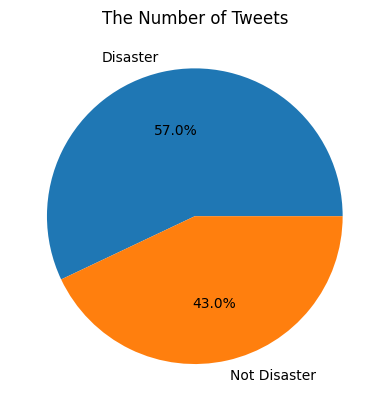

In [90]:
#From the output we can see there are only 7503 unique values out of 7613 values,showing the dataset contains dulicates
#Next we plot a pie chart to show the distribution of the dataset
#We map the values 1 and 0 to disaster and not disaster respectively
values = ['Disaster' if x == 1 else 'Not Disaster' for x in train_dataset.target.unique()]
counts = train_dataset.target.value_counts()

plt.pie(counts, labels=values, autopct='%1.1f%%')
plt.title("The Number of Tweets")
plt.show()

In [91]:
#We can see the data is somewhat evenly distributed

In [92]:
# Cleaning the dataset

#Removing duplicated text
train_dataset.drop_duplicates(inplace=True)



#Function for cleaning text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()
    
    return text

cleaned_train = train_dataset.copy()

# Clean the 'text' column
cleaned_train['text'] = cleaned_train['text'].apply(clean_text)

# Print the cleaned dataset
print(cleaned_train)



                                                   text  target
0     our deeds are the reason of this earthquake ma...       1
1                 forest fire near la ronge sask canada       1
2     all residents asked to shelter in place are be...       1
3     13000 people receive wildfires evacuation orde...       1
4     just got sent this photo from ruby alaska as s...       1
...                                                 ...     ...
7604  worldnews fallen powerlines on glink tram upda...       1
7605  on the flip side im at walmart and there is a ...       1
7606  suicide bomber kills 15 in saudi security site...       1
7608  two giant cranes holding a bridge collapse int...       1
7612  the latest more homes razed by northern califo...       1

[7521 rows x 2 columns]


In [93]:
#Check for null values
null_values = cleaned_train.isnull().sum()

print(null_values)

text      0
target    0
dtype: int64


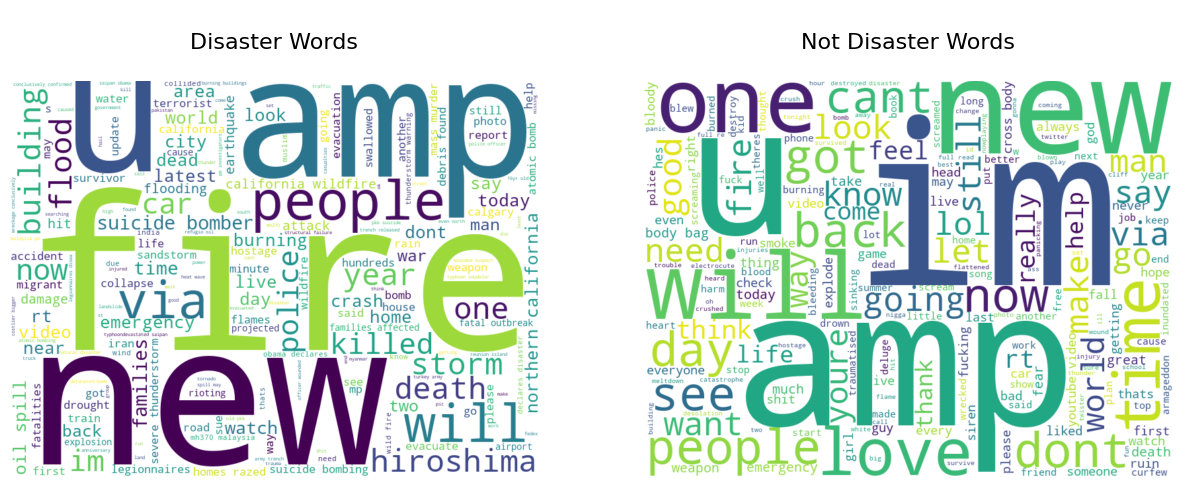

In [94]:
#Plot wordclouds for the different classes(disaster and non-disaster)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

disaster_words = WordCloud(
    background_color='white',
    width=800,
    height=600
).generate(" ".join(cleaned_train[cleaned_train['target'] == 1]['text']))

not_disaster_words = WordCloud(
    background_color='white',
    width=800,
    height=600
).generate(" ".join(cleaned_train[cleaned_train['target'] == 0]['text']))

ax[0].imshow(disaster_words, interpolation='bilinear')
ax[0].set_title('\nDisaster Words\n', fontsize=16)
ax[0].axis('off')
print('\n')
ax[1].imshow(not_disaster_words, interpolation='bilinear')
ax[1].set_title('\nNot Disaster Words\n', fontsize=16)
ax[1].axis('off')

plt.show()

In [95]:
#Processing data for traing on our models

#Spliting data into input features x and y
X = cleaned_train['text'].values
y = cleaned_train['target'].values

#Splitting dataset into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Transforming the training data using a CountVectorizer
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)

# Using a TfidfTransformer to transform the count vectors
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Transforming the test data
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
